**I/O device register**

In [1]:
!nvidia-smi

Fri May 21 10:27:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install required libraries**

In [3]:
!pip3 install transformers pandas nltk spacy classla

     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 266kB 52.1MB/s 
     |████████████████████████████████| 901kB 52.8MB/s 
     |████████████████████████████████| 3.3MB 49.5MB/s 
  Created wheel for obeliks: filename=obeliks-1.0.5-cp37-none-any.whl size=14981 sha256=e2b484397ba7fd0c3bb194f3721780f925d6b250a641da6492cdebb4f3aa2bd0
  Stored in directory: /root/.cache/pip/wheels/60/fc/9e/e3cd0d42fb28369c9df1e0078e60f35f66b430a7c68850d708
Successfully built obeliks


In [4]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html 


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1MB 1.6MB/s eta 0:12:13tcmalloc: large alloc 1147494400 bytes == 0x55932778c000 @  0x7feb54a7b615 0x5592edd26cdc 0x5592ede0652a 0x5592edd29afd 0x5592ede1afed 0x5592edd9d988 0x5592edd984ae 0x5592edd2b3ea 0x5592edd9d7f0 0x5592edd984ae 0x5592edd2b3ea 0x5592edd9a32a 0x5592ede1be36 0x5592edd99853 0x5592ede1be36 0x5592edd99853 0x5592ede1be36 0x5592edd99853 0x5592ede1be36 0x5592ede9e3e1 0x5592eddfe6a9 0x5592edd69cc4 0x5592edd2a559 0x5592edd9e4f8 0x5592edd2b30a 0x5592edd993b5 0x5592edd987ad 0x5592edd2b3ea 0x5592edd993b5 0x5592edd2b30a 0x5592edd993b5
     |█████████████████               | 1055.7MB 1.4MB/s eta 0:11:21tcmalloc: large alloc 1434370048 bytes == 0x55936bde2000 @  0x7feb54a7b615 0x5592edd26cdc 0x5592ede0652a 0x5592edd29afd 0x5592ede1afed 0x5592edd9d988 0x5592edd984ae 0x5592edd2b3ea 0x5592edd9d7f0 0x5592edd984ae 0x5592edd2b3ea 0x5592edd9a32a 0x5592ede1be36 0x5592edd99853 0

# Random seed

In [31]:
import random
import numpy as np
import torch

seed_val = 2021

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT 

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time
import datetime

In [7]:
def setup_classifier(
    model_name: str,
    num_labels: int) -> BertForSequenceClassification:

    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels = num_labels,
        output_attentions = False,
        output_hidden_states = False,
    )
    
    return model

In [9]:
def setup_data(
    model_name: str,
    x: pd.DataFrame, 
    y: pd.DataFrame,
    do_lower_case: bool,
    max_length: int) -> TensorDataset:

    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = do_lower_case)

    input_ids = []
    attention_masks = []

    for text in x:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = max_length,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
            truncation = True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y)

    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [10]:
def train_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset, 
    validation_ratio: float,
    batch_size: int,
    freeze_embeddings_layer: bool,
    freeze_encoder_layers: int,
    epochs: int,
    save_checkpoints: bool) -> (BertForSequenceClassification, list):

    device = select_device()

    train_size = int(validation_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size
    )

    validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset),
        batch_size = batch_size
    )

    modules = []

    if freeze_embeddings_layer:
        modules.append(model.bert.embeddings)
    
    for i in range(freeze_encoder_layers):
        modules.append(model.bert.encoder.layer[i])

    for module in modules:
        for param in module.parameters():
            param.requires_grad = False
    
    model.to(device)

    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr = 5e-5,
    )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )

    training_stats = []

    total_t0 = time.time()

    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            #!nvidia-smi

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask, 
                labels = b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
        

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():

                outputs = model(
                    b_input_ids, 
                    token_type_ids = None, 
                    attention_mask = b_input_mask,
                    labels = b_labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

        if save_checkpoints:
            now = datetime.datetime.now()
            save_checkpoint(
                "drive/MyDrive/models/checkpoint_e" + str(epoch_i + 1) + "_" + str(now) + ".pt",
                model, optimizer, epoch_i, { "train": avg_train_loss, "val": avg_val_loss }
            )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

In [11]:
def test_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset,
    batch_size: int):

    device = select_device()

    prediction_dataloader = DataLoader(
        dataset, 
        sampler = SequentialSampler(dataset), 
        batch_size = batch_size
    )

    print("")
    print("Running Prediction...")

    model.to(device)

    model.eval()

    predictions , true_labels = [], []

    for batch in prediction_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2]
        
        with torch.no_grad():

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask
            )

        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.numpy()
        
        #predictions.append(logits)
        #true_labels.append(label_ids)
        predictions.extend(list(np.argmax(logits, axis=1).flatten()))
        true_labels.extend(list(label_ids))
    
    print('DONE.')

    return predictions, true_labels


In [12]:
def save_checkpoint(path, model, optimizer, epoch, loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, path)


def save_model(path, model):
    torch.save(model.state_dict(), path)


def load_checkpoint(path):
    checkpoint = torch.load(path)
    return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['epoch'], checkpoint['loss']


def load_model(path):
    return torch.load(path)


def select_device():

    if torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    
    return device


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Performance metrics

In [13]:
from sklearn import metrics

def avg_accuracy(predictions,labels):
    return sum(1 for i, j in zip(predictions, labels) if i == j) / len(predictions) 

def round_to_percentages(value):
    return round(round(value, 4) * 100, 2)

def majority_class(data):
    elements_count = {}
    for element in data:
        if element not in elements_count:
            elements_count[element] = 0
        elements_count[element] += 1
    maximum = max(elements_count, key=elements_count.get)
    return elements_count[maximum] / len(data)

def print_performance_metrics(predicted, true):
    matrix = {}
    labels = sorted(list(set(true)))

    for t in labels:
        for p in labels:
            matrix[(t, p)] = sum([1 for i, j in zip(true, predicted) if i == t and j == p]) / len(true)

    print()
    print("Confusion Matrix")
    print("Rows - Actual")
    print("Columns - Predicted")
    print()

    print(("{:>3}"+" | "+"{:>6}"*len(labels)+" | ").format(" ", *[p for p in labels]))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    for t in labels:
        print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | "+"{:>6.2f}").format(t, *[round_to_percentages(matrix[(t, p)]) for p in labels], round_to_percentages(sum([matrix[(t, p)] for p in labels]))))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | ").format(" ", *[round_to_percentages(sum([matrix[(t, p)] for t in labels])) for p in labels]))
    
    print()
    
    y_true = np.array(true)
    y_pred = np.array(predicted)

    print(metrics.classification_report(y_true, y_pred))

# Preprocessing

In [14]:
import spacy
import re
import classla

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

classla.download('sl')
#classla.download('sl', type='nonstandard')

nlp_eng = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
eng_stopwords = set(nlp_eng.Defaults.stop_words)
slo_stopwords = set(stopwords.words('slovene'))

def eng_preprocessing(text, remove_stopwords=True, do_lemmatization=True):

    text = base_preprocessing(text)

    tokens = []

    # split text to single words
    words = word_tokenize(text)

    lemmer = WordNetLemmatizer()

    # remove stopwords and words with length 1
    for word in words:
        if not remove_stopwords or word not in eng_stopwords:
            if do_lemmatization:
                word = lemmer.lemmatize(word)
            tokens.append(word)

    # convert tokens back to text
    preprocessed_text = ' '.join([str(element) for element in tokens])
    return preprocessed_text

def slo_preprocessing(dataset, remove_stopwords=True, do_lemmatization=True):

    # do base proccesing
    dataset['preprocessed'] = dataset['Text'].apply(base_preprocessing)

    # create pipelines
    #tokenizer = classla.Pipeline('sl', processors='tokenize', type='nonstandard', logging_level='WARN')
    #lemmatizer = classla.Pipeline('sl', processors='tokenize, lemma', type='nonstandard', logging_level='WARN')

    tokenizer = classla.Pipeline('sl', processors='tokenize', logging_level='WARN')
    lemmatizer = classla.Pipeline('sl', processors='tokenize, lemma', logging_level='WARN')

    # do tokenization
    documents = '\n'.join(dataset['preprocessed'].values)
    out_docs = tokenizer(documents)

    for i, sentence in enumerate(out_docs.sentences):
        #print("DOCUMENT")
        seq = []
        for word in sentence.words:
            if not remove_stopwords or word.text not in slo_stopwords:
                seq.append(word.text)

        dataset.at[i, 'preprocessed'] = ' '.join(seq)

    # do lemmatization
    if do_lemmatization:
        documents = '\n'.join(dataset['preprocessed'].values)
        out_docs = lemmatizer(documents)
        
        for i, sentence in enumerate(out_docs.sentences):
            dataset.at[i, 'preprocessed'] = ' '.join(word.lemma for word in sentence.words)

    return dataset

def base_preprocessing(text):

    EMOJI_PATTERN = re.compile(
        "(["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "])"
    )
    text = re.sub(EMOJI_PATTERN,"",text)
    # remove (twitter) urls
    text = re.sub(r"http://t.co/[a-zA-Z0-9čČšŠžŽ]+", " ", text)
    text = re.sub(r"https://t.co/[a-zA-Z0-9čČšŠžŽ]+", " ", text)

    # remove all hashtags or @name Mentions (Usernames only allowed to includes characters A-Z, 0-9 and underscores)
    text = re.sub(r"[@#][a-zA-Z0-9_čČšŠžŽ]+", " ", text)

    # remove non alphabetical characters
    text = re.sub(r"[^a-zA-Z0-9\sčČšŠžŽ]", " ", text)

    # remove multiple white spaces
    text = re.sub(' +', ' ', text)

    # convert all letters to lower case
    text = text.lower()

    return text.strip()

def run_dataset_preparation(dataset, lang="eng", remove_stopwords=True, do_lemmatization=True):

    dataset = dataset.dropna(how='any', axis=0)
    if lang == "eng":
        dataset['preprocessed'] = dataset['Text'].apply(eng_preprocessing, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)
    elif lang == "slo":
        dataset = slo_preprocessing(dataset, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)

    x,y = dataset['preprocessed'], dataset['Label']
    data = (x,y)
    return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


2021-05-21 10:36:48 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2021-05-21 10:40:09 INFO: Finished downloading models and saved to /root/classla_resources.


# Other

In [15]:
import matplotlib.pyplot as plt

def distribution_dataset(data):
    distribution = {}
    for element in data:
        if element not in distribution:
            distribution[element] = 0
        distribution[element] += 1
    return distribution

# Binary Eng classification

## Setup

In [ ]:
binary_data = pd.read_csv('drive/MyDrive/Data/Eng/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "eng", remove_stopwords=False, do_lemmatization=False)

Text length distribution

{25: 533, 134: 205, 79: 332, 460: 12, 97: 314, 38: 521, 362: 29, 48: 524, 74: 399, 37: 506, 114: 314, 255: 69, 36: 575, 53: 459, 57: 473, 15: 393, 126: 252, 72: 435, 29: 522, 60: 425, 5: 145, 12: 336, 59: 462, 140: 166, 68: 409, 135: 196, 268: 68, 136: 172, 73: 371, 129: 226, 121: 274, 49: 505, 94: 342, 40: 509, 17: 462, 101: 325, 58: 474, 152: 155, 192: 139, 240: 76, 188: 117, 86: 348, 61: 449, 98: 351, 111: 311, 54: 454, 62: 438, 71: 408, 14: 397, 10: 265, 41: 529, 88: 353, 34: 548, 80: 358, 112: 302, 137: 190, 43: 462, 50: 461, 18: 431, 92: 333, 105: 335, 341: 65, 138: 194, 64: 423, 75: 410, 87: 341, 104: 305, 159: 141, 115: 306, 116: 308, 154: 142, 124: 286, 7: 162, 119: 279, 78: 362, 13: 414, 33: 547, 28: 542, 443: 9, 113: 278, 0: 194, 21: 534, 120: 311, 67: 489, 44: 531, 46: 497, 70: 450, 196: 104, 65: 402, 6: 165, 150: 162, 66: 429, 127: 222, 23: 539, 19: 451, 334: 60, 35: 456, 3: 138, 329: 56, 561: 9, 161: 135, 27: 563, 24: 561, 16: 499, 30: 547, 26: 512, 56: 459, 84: 365, 200:

(0.0, 1000.0)

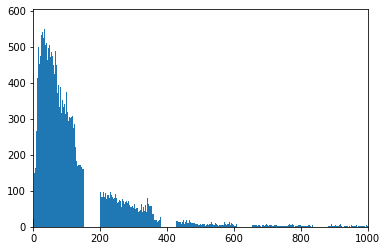

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 512
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed_val))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## Train dataset class distribution

{0: 32458, 1: 25594}


<BarContainer object of 2 artists>

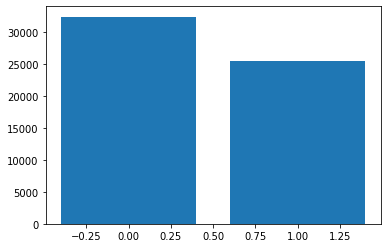

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:blue")

## Test dataset class distribution

{1: 6385, 0: 8128}


<BarContainer object of 2 artists>

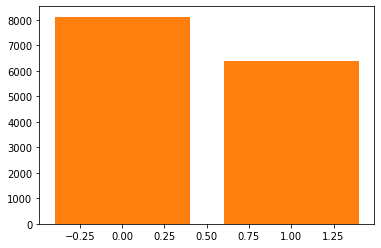

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:orange")

## Train

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun May  2 03:37:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W /  70W |   2016MiB / 15109MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 20,
    freeze_embeddings_layer = True,
    freeze_encoder_layers = 8,
    epochs = 3,
    save_checkpoints = True
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,613.    Elapsed: 0:00:38.
  Batch    80  of  2,613.    Elapsed: 0:01:17.
  Batch   120  of  2,613.    Elapsed: 0:01:58.
  Batch   160  of  2,613.    Elapsed: 0:02:38.
  Batch   200  of  2,613.    Elapsed: 0:03:19.
  Batch   240  of  2,613.    Elapsed: 0:04:01.
  Batch   280  of  2,613.    Elapsed: 0:04:43.
  Batch   320  of  2,613.    Elapsed: 0:05:25.
  Batch   360  of  2,613.    Elapsed: 0:06:08.
  Batch   400  of  2,613.    Elapsed: 0:06:51.
  Batch   440  of  2,613.    Elapsed: 0:07:33.
  Batch   480  of  2,613.    Elapsed: 0:08:16.
  Batch   520  of  2,613.    Elapsed: 0:08:59.
  Batch   560  of  2,613.    Elapsed: 0:09:42.
  Batch   600  of  2,613.    Elapsed: 0:10:25.
  Batch   640  of  2,613.    Elapsed: 0:11:08.
  Batch   680  of  2,613.    Elapsed: 0:11:51.
  Batch   720  of  2,613.    Elapsed: 0:12:34.
  Batch   760  of  2,613.    Elapsed: 0:13:17.
  Ba

In [ ]:
model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/1. binary_checkpoint_e2_2021-05-01 23:32:30.839698.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1 | 
---------------------------
  0 |  49.76  5.83 |  55.59
  1 |   3.70 40.71 |  44.41
---------------------------
    |  53.46 46.54 | 

Majority Class                     :  0.5559
Accuracy                           :  0.9047

Sensitivity, Recall                :  0.8951
Specificity                        :  0.9167
Positive Predictive, Precision     :  0.9308
Negative Predictive                :  0.8747
F1 Score                           :  0.9126


**Saving model**

In [ ]:
save_model("drive/MyDrive/models/binary_5_nostop_400.pt", model)

# Multiclass Eng classification

## Setup

In [40]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Eng/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "eng", remove_stopwords=False, do_lemmatization=False)

Text length distribution

(0.0, 1000.0)

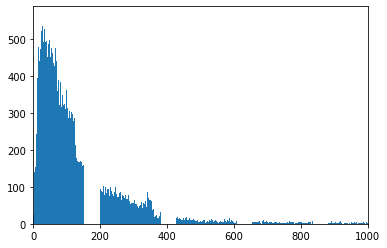

In [41]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [42]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 512
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed_val))

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Train dataset class distribution

{0: 34210, 1: 4577, 5: 1866, 2: 12411, 3: 6686, 4: 562}


<BarContainer object of 6 artists>

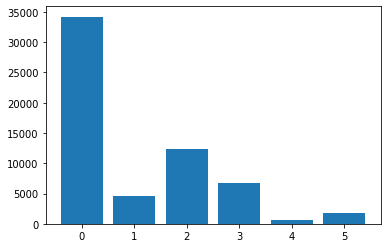

In [43]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:blue")

## Test dataset class distribution

{0: 8621, 3: 1749, 2: 3044, 1: 1105, 5: 417, 4: 142}


<BarContainer object of 6 artists>

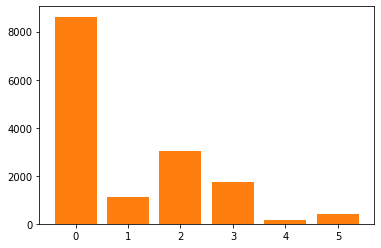

In [44]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:orange")

## Train

In [45]:
torch.cuda.empty_cache()
!nvidia-smi

Fri May 21 11:22:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    36W /  70W |   2848MiB / 15109MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 20,
    freeze_embeddings_layer = True,
    freeze_encoder_layers = 8,
    epochs = 3,
    save_checkpoints = True
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,714.    Elapsed: 0:00:43.
  Batch    80  of  2,714.    Elapsed: 0:01:25.
  Batch   120  of  2,714.    Elapsed: 0:02:07.
  Batch   160  of  2,714.    Elapsed: 0:02:50.
  Batch   200  of  2,714.    Elapsed: 0:03:32.
  Batch   240  of  2,714.    Elapsed: 0:04:14.
  Batch   280  of  2,714.    Elapsed: 0:04:57.
  Batch   320  of  2,714.    Elapsed: 0:05:39.
  Batch   360  of  2,714.    Elapsed: 0:06:21.
  Batch   400  of  2,714.    Elapsed: 0:07:04.
  Batch   440  of  2,714.    Elapsed: 0:07:46.
  Batch   480  of  2,714.    Elapsed: 0:08:29.
  Batch   520  of  2,714.    Elapsed: 0:09:11.
  Batch   560  of  2,714.    Elapsed: 0:09:54.
  Batch   600  of  2,714.    Elapsed: 0:10:36.
  Batch   640  of  2,714.    Elapsed: 0:11:19.
  Batch   680  of  2,714.    Elapsed: 0:12:01.
  Batch   720  of  2,714.    Elapsed: 0:12:43.
  Batch   760  of  2,714.    Elapsed: 0:13:26.
  Ba

## Test

In [23]:
model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/checkpoint_e2_2021-05-21 06:18:16.890388.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [24]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...


KeyboardInterrupt: ignored

## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1     2     3     4     5 | 
---------------------------------------------------
  0 |  45.76  0.45  0.69  0.45  0.10  0.10 |  47.55
  1 |   0.49  4.24  0.20  0.22  0.02  0.00 |   5.18
  2 |   0.24  0.04 26.29  0.10  0.14  0.02 |  26.84
  3 |   0.33  0.69  0.14 14.53  0.04  0.10 |  15.84
  4 |   0.08  0.06  0.02  0.02  2.61  0.00 |   2.79
  5 |   0.20  0.06  0.06  0.49  0.00  0.98 |   1.79
---------------------------------------------------
    |  47.11  5.54 27.42 15.82  2.91  1.20 | 

Majority Class                     :  0.4755
Accuracy                           :  0.9442



**Saving model**

In [ ]:
save_model("drive/MyDrive/models/multiclass.pt", model)

# Binary Slo classification

## Setup

In [ ]:
binary_data = pd.read_csv('drive/MyDrive/Data/Slo/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "slo", remove_stopwords=False, do_lemmatization=False)

Text length distribution

{54: 36, 198: 2, 284: 1, 235: 2, 387: 1, 203: 4, 89: 58, 104: 47, 146: 2, 151: 1, 66: 40, 34: 7, 51: 26, 25: 3, 122: 18, 108: 34, 413: 1, 90: 50, 180: 4, 210: 2, 225: 3, 65: 48, 106: 50, 134: 8, 56: 32, 369: 1, 127: 13, 96: 40, 128: 18, 30: 5, 100: 45, 147: 1, 63: 36, 75: 59, 77: 51, 46: 13, 74: 55, 78: 63, 300: 1, 101: 42, 145: 3, 138: 5, 95: 50, 133: 15, 57: 29, 50: 30, 91: 46, 14: 2, 156: 2, 72: 60, 64: 60, 47: 24, 107: 43, 23: 2, 27: 5, 67: 61, 40: 7, 69: 54, 118: 21, 44: 13, 21: 1, 58: 41, 73: 62, 87: 49, 62: 38, 110: 43, 86: 40, 28: 3, 115: 28, 129: 18, 24: 4, 92: 45, 102: 35, 169: 5, 84: 49, 99: 37, 105: 52, 214: 3, 131: 14, 68: 55, 116: 24, 60: 50, 61: 48, 39: 6, 81: 54, 124: 21, 194: 2, 94: 42, 82: 55, 111: 51, 215: 3, 130: 11, 222: 4, 117: 21, 76: 44, 71: 50, 48: 20, 120: 18, 201: 3, 125: 16, 239: 2, 187: 1, 244: 3, 121: 19, 80: 56, 98: 48, 85: 50, 93: 29, 45: 10, 88: 49, 109: 44, 103: 42, 113: 22, 36: 4, 143: 2, 123: 19, 31: 9, 258: 4, 83: 42, 59: 44, 53: 26, 139: 3, 112: 28

(0.0, 1000.0)

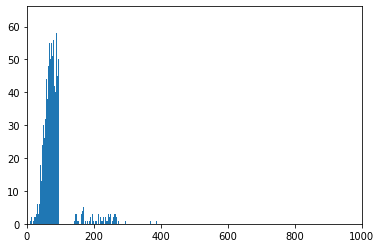

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

#model.load_state_dict(load_model("drive/MyDrive/models/binary_5_nostop_400.pt"))

model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/1. binary_checkpoint_e3_2021-05-02 00:23:14.117783.pt")
model.load_state_dict(model_state_dict)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 512
)

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Dataset class distribution

{0: 2074, 1: 1620}


<BarContainer object of 2 artists>

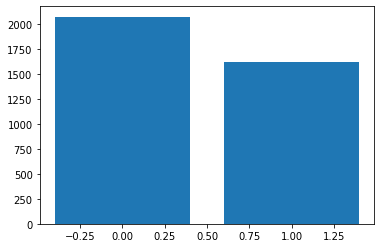

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
yv = list(class_distribution.keys())
xv = list(class_distribution.values())
plt.bar(yv, xv, color="tab:blue")

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1 | 
---------------------------
  0 |  54.06  2.08 |  56.15
  1 |  39.33  4.52 |  43.85
---------------------------
    |  93.39  6.61 | 

              precision    recall  f1-score   support

           0       0.58      0.96      0.72      2074
           1       0.68      0.10      0.18      1620

    accuracy                           0.59      3694
   macro avg       0.63      0.53      0.45      3694
weighted avg       0.63      0.59      0.48      3694



# Multiclass Slo classification

## Setup

In [ ]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Slo/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "slo", remove_stopwords=False, do_lemmatization=False)

Text length distribution

{54: 36, 199: 1, 198: 2, 68: 55, 284: 1, 214: 3, 235: 2, 67: 62, 387: 1, 203: 4, 89: 58, 104: 47, 146: 2, 151: 1, 66: 42, 34: 7, 51: 26, 25: 3, 122: 18, 108: 34, 413: 1, 90: 50, 180: 4, 64: 60, 210: 2, 225: 3, 65: 48, 106: 50, 295: 1, 134: 8, 246: 3, 56: 32, 218: 1, 369: 1, 127: 13, 96: 40, 128: 19, 30: 5, 100: 45, 147: 1, 63: 36, 75: 59, 77: 51, 46: 13, 74: 55, 78: 63, 300: 1, 101: 42, 145: 3, 138: 5, 95: 50, 133: 15, 57: 29, 50: 30, 91: 46, 14: 2, 156: 2, 72: 60, 16: 1, 47: 24, 117: 21, 33: 4, 107: 44, 41: 18, 23: 2, 200: 2, 69: 54, 27: 5, 83: 42, 58: 42, 111: 51, 115: 28, 44: 13, 40: 7, 29: 3, 118: 21, 76: 44, 21: 1, 73: 62, 97: 42, 257: 2, 109: 45, 43: 13, 196: 3, 191: 1, 102: 35, 334: 1, 94: 43, 171: 1, 42: 10, 48: 20, 155: 1, 213: 2, 71: 50, 267: 5, 194: 2, 148: 3, 84: 49, 234: 2, 62: 38, 59: 44, 317: 1, 143: 2, 168: 3, 79: 51, 265: 3, 181: 1, 87: 49, 110: 43, 86: 41, 28: 3, 129: 18, 24: 4, 92: 45, 169: 5, 99: 37, 105: 53, 131: 14, 116: 24, 60: 50, 61: 49, 39: 6, 81: 54, 124: 21,

(0.0, 1000.0)

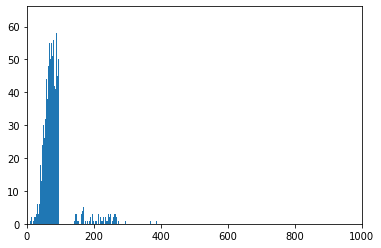

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

#model.load_state_dict(load_model("drive/MyDrive/models/checkpoint_e2_2021-04-23 23:33:32.776693.pt"))

model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/1. multiclass_checkpoint_e3_2021-05-02 01:56:34.069871.pt")
model.load_state_dict(model_state_dict)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 512
)

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Dataset class distribution

{0: 2074, 5: 1491, 4: 9, 1: 58, 2: 53, 3: 23}


<BarContainer object of 6 artists>

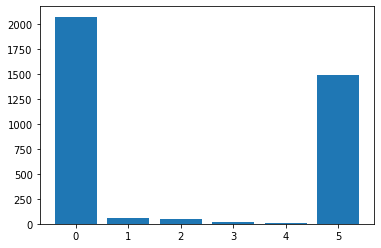

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
yv = list(class_distribution.keys())
xv = list(class_distribution.values())
plt.bar(yv, xv, color="tab:blue")

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1     2     3     4     5 | 
---------------------------------------------------
  0 |  54.56  0.40  0.62  0.16  0.03  0.16 |  55.93
  1 |   1.56  0.00  0.00  0.00  0.00  0.00 |   1.56
  2 |   1.43  0.00  0.00  0.00  0.00  0.00 |   1.43
  3 |   0.59  0.00  0.03  0.00  0.00  0.00 |   0.62
  4 |   0.24  0.00  0.00  0.00  0.00  0.00 |   0.24
  5 |  39.48  0.24  0.16  0.24  0.00  0.08 |  40.21
---------------------------------------------------
    |  97.87  0.65  0.81  0.40  0.03  0.24 | 

              precision    recall  f1-score   support

           0       0.56      0.98      0.71      2074
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00         9
           5       0.33      0.00      0.00      1491

    accuracy                           0.55      3708
   m